In [1]:
import pandas as pd
import numpy as np
from keras.layers import Input, Embedding, Dense, CuDNNLSTM, Dropout, Dense, Bidirectional, BatchNormalization, SpatialDropout1D, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate
from keras.layers import Flatten
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from attention import Attention
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import keras.backend as K
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
train_dataset = pd.read_csv("../data/clean/train_dataset.csv", index_col = 0)
train_dataset.columns = ["review", "sentiment"]
test_dataset = pd.read_csv("../data/clean/test_dataset.csv", index_col = 0)
test_dataset.columns = ["review", "sentiment"]

In [3]:
label_encoder = LabelEncoder()
train_dataset["sentiment"] = label_encoder.fit_transform(train_dataset["sentiment"])
test_dataset["sentiment"] = label_encoder.fit_transform(test_dataset["sentiment"])

In [4]:
#Create word2idx
def get_word_index(texts):
    word_set = set([j for i in texts for j in i.split()])
    w2i = {v:k+2for k,v in enumerate(word_set)}
    w2i["<PAD>"] = 0
    w2i["<UNK>"] = 1
    i2w = {v:k for k,v in w2i.items()}
    return w2i,i2w

In [5]:
MAX_SEQ = 100
EMBEDDING_SIZE = 300
HIDDEN_LAYER = 128

In [6]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [7]:
def create_model(w2i, max_seq, embedding_size, hidden_layer):
    i = Input(shape = (max_seq,))
    o = Embedding(input_dim=len(w2i),
                  output_dim=embedding_size)(i)
    o = SpatialDropout1D(0.3)(o)
    o = Bidirectional(CuDNNLSTM(hidden_layer, return_sequences=True))(o) 
    avg_o = GlobalAveragePooling1D()(o)
    max_o = GlobalMaxPooling1D()(o)
    o = concatenate([avg_o, max_o])
    o = Dropout(0.3)(o)
    o = Dense(hidden_layer, activation='relu')(o)
    o = BatchNormalization()(o)
    o = Dense(1, activation='sigmoid')(o)

    model = Model(inputs = i, outputs = o)
    
    return model

In [ ]:
def save_model(counter, saved_model, w2i, i2w):
    counter = str(counter)
    model_path = "../model/model_"+counter+"/ensemble_model_"+counter+".h5"
    w2i_path = "../model/model_"+counter+"/w2i_model_"+counter+".pkl"
    i2w_path = "../model/model_"+counter+"/i2w_model_"+counter+".pkl"
    saved_model.save(model_path)
    pickle.dump(w2i,open(w2i_path, "wb"))
    pickle.dump(i2w, open(i2w_path, "wb"))

In [8]:
best_auc = 0
count = 0
skf = StratifiedKFold(n_splits = 10)
pred_cv = np.zeros(len(train_dataset))
pred_test = np.zeros(len(test_dataset))

In [9]:
for train_index, val_index in skf.split(train_dataset, train_dataset["sentiment"].values):
    print("Iteration ke-", count)
    train_set, val_set = train_dataset.iloc[train_index,:], train_dataset.iloc[val_index,:]
    train_set = train_set.reset_index(drop = True)
    val_set = val_set.reset_index(drop = True)
    
    train_text = train_set["review"]
    val_text = val_set["review"]
    test_text = test_dataset["review"].values
   
    y_train, y_val = train_set["sentiment"].values, val_set["sentiment"].values
    y_test = test_dataset["sentiment"]
        
    word_2_index, index_2_word = get_word_index(train_text)
    
    X_train_tokenized = pad_sequences([[word_2_index.get(j,1) for j in i.split()] for i in train_text], maxlen = MAX_SEQ)
    X_val_tokenized = pad_sequences([[word_2_index.get(j,1) for j in i.split()] for i in val_text], maxlen = MAX_SEQ)
    X_test_tokenized = pad_sequences([[word_2_index.get(j,1) for j in i.split()] for i in test_text], maxlen = MAX_SEQ)
    
    model = create_model(w2i=word_2_index, 
                         max_seq=MAX_SEQ,
                         embedding_size=EMBEDDING_SIZE,
                         hidden_layer=HIDDEN_LAYER)
    model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=[f1])
    
    e_s = EarlyStopping(monitor='val_f1', patience=3, min_delta=0.0001 ,verbose = 1, mode='max', restore_best_weights=True)
    l_r = ReduceLROnPlateau(monitor='val_f1', factor=0.5, patience=3, min_lr=1e-6, mode='max', verbose=1)
    
    model.fit(X_train_tokenized, 
              y_train, 
              batch_size=32, 
              epochs = 100,
              validation_data=(X_val_tokenized, y_val),
              verbose=1,
              callbacks=[e_s, l_r],
              shuffle = True)
    
    val_pred = model.predict(X_val_tokenized)[:,0]
    test_pred = model.predict(X_test_tokenized)[:,0]
    pred_cv[[val_index]] += val_pred
    pred_test += test_pred
    
#     save_model(counter=count, saved_model=model, w2i = word_2_index, i2w=index_2_word)
    val_pred_tmp = [1 if i>0.6 else 0 for i in val_pred]
    print("AUC Score: ", roc_auc_score(y_val, val_pred_tmp))
    print("PRF1 Score: ",precision_recall_fscore_support(y_val, val_pred_tmp, average='macro'))
    print("ACCURACY Score: ",accuracy_score(y_val, val_pred_tmp))
    count += 1 

Iteration ke- 0
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 1602 samples, validate on 178 samples
Epoch 1/100
1602/1602 [==============================] - 5s 3ms/step - loss: 0.5847 - f1: 0.7488 - val_loss: 0.5896 - val_f1: 0.7193
Epoch 2/100
1602/1602 [==============================] - 3s 2ms/step - loss: 0.2866 - f1: 0.9006 - val_loss: 0.5849 - val_f1: 0.7193
Epoch 3/100
1602/1602 [==============================] - 3s 2ms/step - loss: 0.1541 - f1: 0.9546 - val_loss: 0.6090 - val_f1: 0.7193
Epoch 4/100
1602/1602 [==============================] - 3s 2ms/step - loss: 0.0924 - f1: 0.9720 - val_loss: 0.4428 - val_f1: 0.7254
Epoch 5/100
1602/1602 [==============================] - 3s 2ms/step - loss: 0.0579 - f1: 0.9855 - val_loss: 0.5125 - val_f1: 0.7273
Epoch 6/100
1602/1602 [==============================] - 3s 2ms/step - loss: 0.0357 - f1: 0.9748 - val_loss: 0.4660 - val_f1: 0.7125
Epoch 7/100
1602/1602 [=====================

*We want to look for the best threshold that giving best result in the validation data, then we will use it for the testing data*

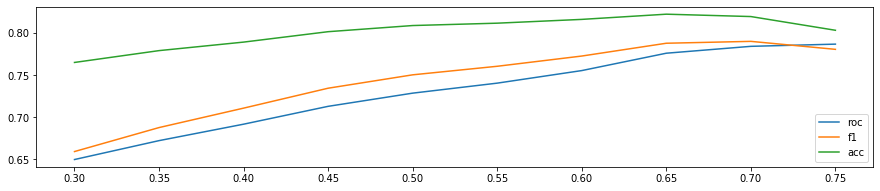

In [11]:
roc_scores = []
f1_scores = []
acc_scores = []
threshold = np.arange(0.3, 0.8, 0.05)

for th in threshold:
    pred_cv_tmp = np.asarray([1 if i>th else 0 for i in pred_cv])
    roc_score = roc_auc_score(train_dataset["sentiment"], pred_cv_tmp)
    roc_scores.append(roc_score)
    a,b,c,d = precision_recall_fscore_support(train_dataset["sentiment"], pred_cv_tmp, average='macro')
    f1_scores.append(c)
    acc_score = accuracy_score(train_dataset["sentiment"], pred_cv_tmp)
    acc_scores.append(acc_score)
plt.figure(figsize = (15,10))
plt.subplot(3,1,1)
plt.plot(threshold,roc_scores,label= "roc")
plt.plot(threshold,f1_scores,label= "f1")
plt.plot(threshold,acc_scores,label="acc")
plt.xticks(threshold)
plt.legend()

In [ ]:
def print_metrics(y_true, y_pred):
    print("AUC Score: %.2f" %roc_auc_score(y_true, y_pred))
    print("F1 Score: %.2f" %f1_score(y_true, y_pred, average='macro'))
    print("ACCURACY Score: %.2f" %accuracy_score(y_true, y_pred))

In [14]:
import copy
tmp_pred_cv = [1 if i > 0.65 else 0 for i in pred_cv]
tmp_pred_test = copy.deepcopy(pred_test)
tmp_pred_test /= count
tmp_pred_test = [1 if i > 0.65 else 0 for i in tmp_pred_test]

print("predict on validation data")
print_metrics(train_dataset["sentiment"], tmp_pred_cv)
print("==")
print("predict on test data")
print_metrics(test_dataset["sentiment"], tmp_pred_test)

predict on validation data
AUC Score:  0.7761350574712643
PRF1 Score:  (0.807191402029295, 0.7761350574712644, 0.7879735049810093, None)
ACCURACY Score:  0.8224719101123595
==
predict on test data
AUC Score:  0.8080128205128204
PRF1 Score:  (0.8292900219298245, 0.8080128205128205, 0.816565309360127, None)
ACCURACY Score:  0.8378378378378378


**plain model is not overfit**